Loading useful libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import roots_legendre
from scipy.special import eval_legendre
from scipy.linalg import solve
from matplotlib import animation
from IPython.display import HTML
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import os
import csv

User input

In [2]:
#Physical constants
rho_in_CGS = 1 #Gr/cm^3
sigma_in_CGS = 72 #Dyne/cm
g_in_CGS = 980 #Cm/s2
nu_in_GCS = 0.01 #cm2/s

#Geometry
R_in_CGS = .02 #Cm

#Initial speed in meters per second
V_in_CGS = 30 #Cm/s

#Total simulation time
T_end = 5 #In dimensionless units

#Numerical parameters
n_thetas = 40
n_sampling_time_L_mode = 16 #Not any less than 8

Constanst derived directly from user input

In [3]:
#Initial height
H_in_CGS = R_in_CGS

#Units
unit_length_in_CGS = R_in_CGS
unit_time_in_CGS = np.sqrt(rho_in_CGS*R_in_CGS**3/sigma_in_CGS)
unit_mass_in_CGS = rho_in_CGS*R_in_CGS**3

#Dimensionless constansts
We = rho_in_CGS*V_in_CGS**2*R_in_CGS/sigma_in_CGS
Bo = rho_in_CGS * g_in_CGS * R_in_CGS**2/ sigma_in_CGS
Oh = nu_in_GCS * np.sqrt((rho_in_CGS)/(sigma_in_CGS*R_in_CGS))

#Numerical constants
delta_time_max = (2*np.pi
                  /(np.sqrt(n_thetas*(n_thetas+2)*(n_thetas-1))
                    *n_sampling_time_L_mode))
n_times_base = int(np.ceil(T_end/delta_time_max))

#Initialize list of times
times_list = (np.linspace(0,n_times_base,n_times_base+1)
              * delta_time_max).tolist()

#Dimensionless initial conditions
V = -np.sqrt(We)
H = H_in_CGS/unit_length_in_CGS

#Define vector of cosines of the sampled angles
roots, weights = roots_legendre(n_thetas)
cos_theta_vec = np.concatenate(([1], np.flip(roots)))
theta_vec = np.arccos(cos_theta_vec)
q_last = np.argmax(cos_theta_vec <= 0)

Useful Functions

In [4]:
def Legendre(x, n):  #Define Legendre Polynomial of cosine
    """
    Function that evaluates nth Legendre polynomial at x with a scipy function eval_legendre.

    Inputs:
    x (float): X-value at which Legendre polynomial is evaluated
    n (int): Number of Legendre polynomial to be evaluated
    
    Output:
    value (float): value of nth Legendre polynomial at x

    """
    if n == n_thetas and x != 1:
        #To avoid numerical errors very close to zero
        value = 0
    else:
      value = eval_legendre(n, x)
    return value

In [5]:
def matrix(delta_t,q): #Define function for matrix

    """
    Function that creates the matrix with a given time step and a given number of conact points.
    
    Inputs:
    delta_t (float): Chosen time-step-size.
    q (int): Number of guessed contact points.

    Output:
    M_mat (matrix): Filled matrix with q guessed contact points.

    """
    #First Block Row
    #Identity Matrix I(n_thetas -1)
    Identity_n_thetas_min_1_mat = np.eye((n_thetas-1)) #Condition Number = 1

    M_mat = np.concatenate((Identity_n_thetas_min_1_mat,
                            -delta_t*Identity_n_thetas_min_1_mat,
                            np.zeros((n_thetas-1,n_thetas+1)),
                            np.zeros((n_thetas-1,1)),
                            np.zeros((n_thetas-1,1))
                           ),
                           1
                          )
    #Second Block Row
    C_list = [((l - 1) * (l) * (l + 2)) for l in range(2, n_thetas+1)]
    C_mat = np.diag(C_list)
    D_list = [l for l in range(2, n_thetas+1)]
    D_mat = np.concatenate((np.zeros((n_thetas-1, 2)),
                            np.diag(D_list)),1)
    second_block_row = np.concatenate((delta_t*C_mat,
                                            Identity_n_thetas_min_1_mat,
                                            delta_t*D_mat,
                                            np.zeros((n_thetas-1,1)),
                                            np.zeros((n_thetas-1,1))
                                           ),
                                           1
                                          )
    M_mat = np.concatenate((M_mat,
                            second_block_row),
                           0
                          )
    #Third and fourth rows of blocks
    EG_mat = np.zeros((n_thetas+1,n_thetas+1))
    for ind_angle in range(n_thetas+1):
      for ind_poly in range(n_thetas+1):
        EG_mat[ind_angle,ind_poly] = Legendre(cos_theta_vec[ind_angle],ind_poly)
    E_mat = EG_mat[0:q,2:]
    G_mat = EG_mat[q:,:]
    F_vec = np.transpose([-1/cos_theta_vec[0:q]])
    third_block_row = np.concatenate((E_mat,
                                      np.zeros((q,n_thetas-1)),
                                      np.zeros((q,n_thetas+1)),
                                      F_vec,
                                      np.zeros((q,1))
                                     ),
                                     1
                                    )
    fourth_block_row = np.concatenate((np.zeros((n_thetas+1-q,n_thetas-1)),
                                       np.zeros((n_thetas+1-q,n_thetas-1)),
                                       G_mat,
                                       np.zeros((n_thetas+1-q,1)),
                                       np.zeros((n_thetas+1-q,1))
                                      ),
                                      1
                                     )
    M_mat = np.concatenate((M_mat,
                            third_block_row,
                            fourth_block_row
                           ),
                           0
                          )
    #Fifth block row
    fifth_block_row = np.concatenate((np.zeros((1,n_thetas-1)),
                                      np.zeros((1,n_thetas-1)),
                                      np.zeros((1,n_thetas+1)),
                                      [[1]],
                                      [[-delta_t]]
                                     ),
                                     1
                                    )
    M_mat = np.concatenate((M_mat,
                            fifth_block_row
                           ),
                           0
                          )
    #Sixth row of blocks
    H = np.zeros((1,n_thetas+1))
    H[0,1] = -1
    sixth_block_row = np.concatenate((np.zeros((1,n_thetas-1)),
                                      np.zeros((1,n_thetas-1)),
                                      delta_t*H,
                                      [[0]],
                                      [[1]]
                                     ),
                                     1
                                    )
    M_mat = np.concatenate((M_mat,
                            sixth_block_row
                           ),
                           0
                          )
    return M_mat

In [6]:
def condition_number(matrix): #Optional (calculating condition number)
    return np.linalg.cond(matrix)

In [7]:
def error(amplitudes_vec, h, q): #Defining the Error function

    """
    Function that calculates the error of q contact points.

    Inputs:
    amplitudes_vec (vector): Vector of amplitudes for q contact points at k+1.
    h (float): Height of the center of mass at k+1.
    q (int): Number of guessed contact points.

    Outputs:
    err (float): Error at k+1 with q contact points.
    """

    if q < 0: #Handling impossible situation
        return np.inf

    if q == 0: 
      all_verticals_list = []
      for ind_theta in range(n_thetas+1):
          cos_theta = cos_theta_vec[ind_theta]
          height = ((1
                     + np.sum([amplitudes_vec[l]*Legendre(cos_theta, l+2) for l in range(n_thetas-1)])
                    )
                    *cos_theta
                   )
          all_verticals_list.append(height)

      for vertical in all_verticals_list: #Checking whether droplet crosses surface (physically impossible)
        if vertical > h:
          return np.inf
      return 0 #Else, not in contact

    #Variables to store sums
    sum_q = 1
    sum_qp1 = 1

    #Extracting the cos(theta) values at q (= q-1 in list index) and q+1 (= q in list index)
    cos_theta_q = cos_theta_vec[q-1]
    cos_theta_q_plus_1 = cos_theta_vec[q]

    for ind_poly in range(n_thetas-1):
      sum_q += (amplitudes_vec[ind_poly]
                *Legendre(cos_theta_q,ind_poly+2)
               )
      sum_qp1 += (amplitudes_vec[ind_poly]
                  *Legendre(cos_theta_q_plus_1,ind_poly+2)
                 )
    #Calculating the vertical components of each point
    vertical_q = sum_q * cos_theta_q
    vertical_qp1 = sum_qp1 * cos_theta_q_plus_1

    #Regular error calculation
    err1 = np.abs(vertical_q - vertical_qp1)
    err2 = 0 #Err2 for checking whether droplet crosses surface (physically impossible)
    for ind_theta in range(q,n_thetas+1):
      rad = 1
      for ind_poly in range(2,n_thetas+1):
        rad += (amplitudes_vec[ind_poly-2]
                *Legendre(cos_theta_vec[ind_theta],ind_poly)
               )
      if rad*cos_theta_vec[ind_theta]>(h):
        err2 = np.inf
        break
    err = np.max([err1,[err2]]) #Return highest error

    return err

In [8]:
def try_q(amps_prev_vec, amps_vel_prev_vec, h_prev, v_prev, q, delta_t):

  """
  Function that "tries" q contact points by solving the system of equations.

  Inputs:
  amps_prev_vec (vector): Vector of amplitudes at the previous time (k).
  amps_vel_prev_vec (vector): Vector of velocities of amplitudes at the previous time (k).
  h_prev (float): Height of the center of mass at the previous time (k).
  v_prev (float): Velocity of the center of mass at the previous time (k).
  delta_t (float): Time step (in non-dimensional time).
  q (int): Number of guessed contact points.
  n_thetas (int): Total number of sampled angles.
  Bo (float): Bond (non-dimensional gravity).

  Outputs:
  sol_vec (vector): Vector of the solution of matrix at q contact points at time k+1
  err (float): Error at k+1 with q contact points.
  
  """
  #Extracting samling angles
  roots, weights = roots_legendre(n_thetas)
  cos_theta_vec = np.concatenate(([1], np.flip(roots)))
  q_last = np.argmax(cos_theta_vec <= 0)

  #Running through different guesses of q
  if q < 0: #Return previous matrix and infinite error for physically impossible case
    sol_vec = np.concatenate((amps_prev_vec,
                              amps_vel_prev_vec,
                              np.zeros((n_thetas+1,1)),
                              h_prev,
                              v_prev
                             ),
                             0
                            )
    err = np.inf

  elif q == 0: #Only solve necessary parts of the matrix (no contact and pressure block-rows)
    #Right-hand side for mode equations
    RHS_modes_vec = np.concatenate((amps_prev_vec,
                                    amps_vel_prev_vec
                                   ),
                                   0
                                  )
    #Right-hand side for cm equations
    RHS_h_vec = np.concatenate((h_prev,
                                v_prev-(delta_t*Bo)
                               ),
                               0
                              )

    #Extracting parts of the matrices for modes and cm
    M_modes_mat = matrix(delta_t, q)[: int(n_thetas*2-2), : int(n_thetas*2-2)]
    M_h_mat = matrix(delta_t, q)[-2:,-2:]

    #Solving systems of equations
    sol_modes_vec = solve(M_modes_mat, RHS_modes_vec)
    sol_h_vec = solve(M_h_mat, RHS_h_vec)
    sol_vec = np.concatenate((sol_modes_vec,
                              np.zeros((n_thetas+1,1)),
                              sol_h_vec
                             ),
                            0
                           )

    #Calculating the error at k+1, q=0
    err = error(sol_modes_vec[: n_thetas-1],
                sol_h_vec[0],
                q)

  elif q <= q_last: #Solving the full matrix with guessed contact points
    RHS_vec = np.concatenate((amps_prev_vec,
                              amps_vel_prev_vec,
                              -np.ones((q,1)),
                              np.zeros((n_thetas+1-q,1)),
                              h_prev,
                              v_prev-(delta_t*Bo)
                             ),
                             0
                            )
    M_mat = (matrix(delta_t, q))
    sol_vec = (solve(M_mat, RHS_vec))

    #Calculating the error at k+1, q
    err = error(sol_vec[: n_thetas-1], sol_vec[-2], q)

  else: #Assumptions of little deformation in the model do not allow for this case; returns sample matrix and infinite error 
    sol_vec = np.concatenate((amps_prev_vec,
                              amps_vel_prev_vec,
                              np.zeros((n_thetas+1,1)),
                              h_prev,
                              v_prev
                             ),
                             0
                            )
    err = np.inf

  return (sol_vec, err)

In [9]:
def north_and_south_pole(all_amps_vec, h):

    """
    Function that evaluates the deformed droplet's north and south pole radii.

    Inputs:
    amps_prev_vec (vector): Vector of amplitudes at a single point in time.
    h (float): Height of the center of mass.
    n_thetas (int): Total number of sampled angles.

    Outputs:
    deformed_north_pole_radius (vector): Radius at the north pole.
    deformed_south_pole_radius (vector): Radius at the south pole.

    """

    #Setting undeformed radii
    undeformed_north_pole_radius = 1
    undeformed_south_pole_radius = 1

    #Adding deformations from the Legendre modes
    for i in range(2, n_thetas):
        undeformed_north_pole_radius += all_amps_vec[i-2] * Legendre(-1, i)
        undeformed_south_pole_radius += all_amps_vec[i-2] * Legendre(1, i) 

    #Converting to radians to convert to xy-coordinates/ height
    radian_north_pole = (np.pi)/2
    radian_south_pole = (np.pi*3)/2 

    #Obtaining xy coordinates
    deformed_north_pole_radius = undeformed_north_pole_radius * np.sin(radian_north_pole) + h
    deformed_south_pole_radius = undeformed_south_pole_radius * np.sin(radian_south_pole) + h

    return[deformed_north_pole_radius, deformed_south_pole_radius]

In [10]:
def maximum_radius(all_amps_vec):

    """
    Function that calculates the maximum radius of the droplet at a single point in time.

    Inputs:
    amps_prev_vec (vector): Vector of amplitudes at a single point in time.

    Outputs:
    radius_of_largest_deformation (vector): Radius of the angle, where largest radius is achieved.

    """

    radii = np.ones(n_thetas) #Setting radi at all sampled points to an undeformed radius
    for i in range(2, n_thetas):
        for ind_angles in range(n_thetas): #Adding deformation
            radii[ind_angles] += all_amps_vec[i - 2][0] * Legendre(np.cos(theta_vec[ind_angles]), i)

    radius_of_largest_deformation = np.max(radii)
    return radius_of_largest_deformation #Returning largest radius

In [11]:
def coefficient_of_restitution(all_h_list, all_v_list, all_m_list, all_time_list):

    """
    Function that calculates the coefficient of restitution and contact time for a droplet impact.

    Inputs:
    all_h_list (list): List of heights of the center of mass of the droplet at every time step.
    all_v_list (list): List of velocities of the center of mass of the droplet at every time step.
    all_m_list (list): List of contact points at every time step.
    all_time_list (list): List of all time steps.

    Outputs:
    coeff_rest_squared_float (float): Coefficient of Restitution.
    contact_time_float (float): Time of contact (non-dimensional).

    """
    
    #Setting all values to be obtained to None to avoid errors
    final_velocity = None
    final_height = None
    contact_time = None
    index = None
    
    for i in range(1, len(all_m_list)-1):
        if all_m_list[i] == 0 and all_m_list[i-1] > 0: #Marks end of contact
            index = i
            break


    #Averages of last contact and first non-comtact times
    final_velocity = (all_v_list[index] + all_v_list[index-1])/2 
    final_height = (all_h_list[index] + all_h_list[index-1])/2
    contact_time = (all_time_list[index] + all_time_list[index-1])/2

    #Handling if no take-off occurs
    if final_velocity == None:
        return None

    #Calculating of coefficient of restitution squared
    coeff_rest_squared = (((Bo * (final_height - 1)) 
                          + 0.5 * (final_velocity**2))/ 
                          (0.5 * (We)))
    
    coeff_rest_squared_float = np.sqrt(np.abs(float(coeff_rest_squared[0][0])))


    return [coeff_rest_squared_float, contact_time]

In [12]:
def maximum_contact_radius(all_amps_list, all_m_list):

    """
    Function that calculates the maximum contact radius of a droplet impact.

    Inputs:
    all_amps_list (list): List of all amplitudes at every time step.
    all_m_list (list): List of contact points at every time step.

    Outputs:
    np.max(contact_radii) (float): Maximum contact radius achieved during impact.

    """

    contact_areas = []
    new_aplitudes = np.asarray(all_amps_list) #Converting to array for easier handling
    for time in range(len(all_amps_list)):
        m = all_m_list[time]
        radius = np.ones(2)
        if m == 0: #If not in contact, contact area = 0
            contact_areas.append(0)
        else: 
            for i in range(2, n_thetas):
                radius[0] += new_aplitudes[time, i - 2][0] * Legendre(np.cos(theta_vec[m-1]), i)
                radius[1] += new_aplitudes[time, i - 2][0] * Legendre(np.cos(theta_vec[m]), i)

            new_thetas = [theta + 3 * np.pi / 2 for theta in theta_vec]
            x_1 = radius[0] * np.cos(new_thetas[m-1])
            x_2 = radius[1] * np.cos(new_thetas[m])

            #Calculating average of last contact-point-radius and first non-contact-point radius
            contact_areas.append((x_1+x_2)/2)

    return np.max(contact_areas) #Returning largest contact area

Simulations

In [13]:
#Main time loop

"""
  Runs the simulation of an impacting droplet.

  Inputs/ Uses:
  n_thetas (int): Total number of sampled angles.
  n_sampling_time_L_mode
  T_end (int): Duration of simulation.
  H (float): Initial height.
  V (float): Initial velocity.
  Bo (float): Bond Number, non-dimensional gravity.

  Outputs/ Creates/ Appends:
  all_amps_list (list): List of all amplitudes at all time steps.
  all_amps_vel_list (list): List of all amplitude velocities at all time steps.
  all_press_list (list):  List of all pressure amplitudes at all time steps.
  all_h_list (list): List of heights of the center of mass of the droplet at every time step.
  all_v_list (list): List of velocities of the center of mass of the droplet at every time step.
  all_m_list (list): List of contact points at every time step.
  all_north_poles_list (list): List of north poles at every time step.
  all_south_poles_list (list): List of south poles at every time step.
  all_maximum_radii_list (list): List of maximum radii at every time step.
  all_times_list (list): List of all time steps.

"""

#Current values of variables 
amps_prev_vec = np.zeros((n_thetas-1,1))
amps_vel_prev_vec = np.zeros((n_thetas-1,1))
h_prev = H*np.ones((1,1))
v_prev = V*np.ones((1,1))
m_prev = 0

#Variables to store values of simulation
all_amps_list = [amps_prev_vec]
all_amps_vel_list = [amps_vel_prev_vec]
all_press_list = [np.zeros((n_thetas+1,1))]
all_north_poles_list = []
all_h_list = [h_prev]
all_v_list = [v_prev]
all_m_list = [0]
all_north_poles_list = [north_and_south_pole(amps_prev_vec, H)[0]]
all_south_poles_list = [north_and_south_pole(amps_prev_vec, H)[1]]
all_maximum_radii_list = [maximum_radius(amps_prev_vec)]

#Initializing counter
ind_time = 0 #This counts the last time for which we have a successful solution
while times_list[ind_time] < times_list[-1]:
    #Time step is the difference in the times_list
    delta_t = times_list[ind_time+1] - times_list[ind_time]

    #Set all errors to infinity
    err_m_prev = np.inf
    err_m_prev_m1 = np.inf
    err_m_prev_m2 = np.inf
    err_m_prev_p1 = np.inf
    err_m_prev_p2 = np.inf

    #Calculate solution vectors and errors for initial comparison (q=q_{k-1}; q=q_{k-1}-1)
    sol_vec_m_prev, err_m_prev = try_q(amps_prev_vec,
                                      amps_vel_prev_vec,
                                      h_prev,
                                      v_prev,
                                      m_prev,
                                      delta_t)
    sol_vec_m_prev_m1, err_m_prev_m1 = try_q(amps_prev_vec,
                                            amps_vel_prev_vec,
                                            h_prev,
                                            v_prev,
                                            m_prev-1,
                                            delta_t)

    #If one contact point less is better than the previous contact points, test two contact points less (q=q_{k-1}-2)
    if err_m_prev_m1 < err_m_prev:
        sol_vec_m_prev_m2, err_m_prev_m2 = try_q(amps_prev_vec,
                                                amps_vel_prev_vec,
                                                h_prev,
                                                v_prev,
                                                m_prev-2,
                                                delta_t)
        if err_m_prev_m2 < err_m_prev_m1:
          #If two contact points less were better, the time step was too large: Insert new time step
          time_insert = (times_list[ind_time] + times_list[ind_time+1])/2
          times_list.insert(ind_time+1, time_insert)

        else: 
          #Accept solution, update variables, append to lists, and move forward in time
          ind_time += 1
          m_prev -= 1
          amps_prev_vec = sol_vec_m_prev_m1[:(n_thetas-1)]
          amps_vel_prev_vec = sol_vec_m_prev_m1[(n_thetas-1):(2*n_thetas-2)]
          press_prev_vec = sol_vec_m_prev_m1[(2*n_thetas-2):-2]
          h_prev = np.reshape(sol_vec_m_prev_m1[-2],(1,1))
          v_prev = np.reshape(sol_vec_m_prev_m1[-1],(1,1))
          all_amps_list.append(amps_prev_vec)
          all_amps_vel_list.append(amps_vel_prev_vec)
          all_press_list.append(press_prev_vec)
          all_h_list.append(h_prev)
          all_v_list.append(v_prev)
          all_m_list.append(m_prev)
          all_north_poles_list.append(north_and_south_pole(amps_prev_vec, h_prev)[0])
          all_south_poles_list.append(north_and_south_pole(amps_prev_vec, h_prev)[1])
          all_maximum_radii_list.append(maximum_radius(amps_prev_vec))

    else: #If one contact point less is not better, try one contact point (more q=q_{k-1}+1)
      sol_vec_m_prev_p1, err_m_prev_p1 = try_q(amps_prev_vec,
                                              amps_vel_prev_vec,
                                              h_prev,
                                              v_prev,
                                              m_prev+1,
                                              delta_t)
      if err_m_prev_p1 < err_m_prev:
        sol_vec_m_prev_p2, err_m_prev_p2 = try_q(amps_prev_vec,
                                                amps_vel_prev_vec,
                                                h_prev,
                                                v_prev,
                                                m_prev+2,
                                                delta_t)
        if err_m_prev_p2 < err_m_prev_p1: #If one contact point more is better than the previous contact points, test two contact points more (q=q_{k-1}+2)
          #If two contact points less were better, the time step was too large: Insert new time step
          time_insert = (times_list[ind_time] + times_list[ind_time+1])/2
          times_list.insert(ind_time+1, time_insert)
        else:
          #Accept solution, update variables, append to lists, and move forward in time
          ind_time += 1
          m_prev += 1
          amps_prev_vec = sol_vec_m_prev_p1[:(n_thetas-1)]
          amps_vel_prev_vec = sol_vec_m_prev_p1[(n_thetas-1):(2*n_thetas-2)]
          press_prev_vec = sol_vec_m_prev_p1[(2*n_thetas-2):-2]
          h_prev = np.reshape(sol_vec_m_prev_p1[-2],(1,1))
          v_prev = np.reshape(sol_vec_m_prev_p1[-1],(1,1))
          all_amps_list.append(amps_prev_vec)
          all_amps_vel_list.append(amps_vel_prev_vec)
          all_press_list.append(press_prev_vec)
          all_h_list.append(h_prev)
          all_v_list.append(v_prev)
          all_m_list.append(m_prev)
          all_north_poles_list.append(north_and_south_pole(amps_prev_vec, h_prev)[0])
          all_south_poles_list.append(north_and_south_pole(amps_prev_vec, h_prev)[1])
          all_maximum_radii_list.append(maximum_radius(amps_prev_vec))
          
      elif err_m_prev_p1 == np.inf and err_m_prev == np.inf and err_m_prev_m1 == np.inf:
        #If all errors are infinite, reduce the time step
        time_insert = (times_list[ind_time] + times_list[ind_time+1])/2
        times_list.insert(ind_time+1, time_insert)

      else: 
        #Accept solution, update variables, append to lists, and move forward in time
        ind_time += 1
        amps_prev_vec = sol_vec_m_prev[:(n_thetas-1)]
        amps_vel_prev_vec = sol_vec_m_prev[(n_thetas-1):(2*n_thetas-2)]
        press_prev_vec = sol_vec_m_prev[(2*n_thetas-2):-2]
        h_prev = np.reshape(sol_vec_m_prev[-2],(1,1))
        v_prev = np.reshape(sol_vec_m_prev[-1],(1,1))
        all_amps_list.append(amps_prev_vec)
        all_amps_vel_list.append(amps_vel_prev_vec)
        all_press_list.append(press_prev_vec)
        all_h_list.append(h_prev)
        all_v_list.append(v_prev)
        all_m_list.append(m_prev)
        all_north_poles_list.append(north_and_south_pole(amps_prev_vec, h_prev)[0])
        all_south_poles_list.append(north_and_south_pole(amps_prev_vec, h_prev)[1])
        all_maximum_radii_list.append(maximum_radius(amps_prev_vec))

# Simple Plots

Calling Functions

In [14]:
print(coefficient_of_restitution(all_h_list, all_v_list, all_m_list, times_list))
print(maximum_contact_radius(all_amps_list, all_m_list))

[np.float64(0.9522848520238659), 2.596579468111938]
0.6147691361848813


Simple plots

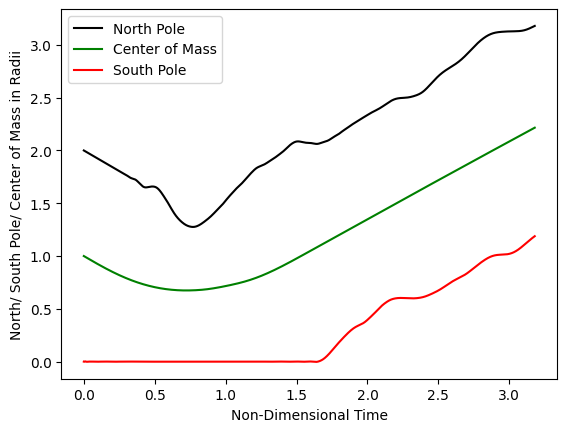

In [15]:
#Heights Plots

"""
Creating a plot of all north pole, south pole and center of mass heights and saves it to a designated folder.

Inputs/ Uses:
all_north_poles_list (list): List of north poles at every time step.
all_south_poles_list (list): List of south poles at every time step.
all_h_list (list): List of heights of the center of mass of the droplet at every time step.
all_times_list (list): List of all time steps.

Outputs:
plot_path (saved plot): Saves plot on computer.
    
"""

#Create times list t for x-axes
t_intervall = len(all_north_poles_list)
t = np.linspace(0, all_north_poles_list[-1].item(), t_intervall)

#Convert arrays within storage lists to simple floats for plotting
all_north_poles_float_list = [arr.item() for arr in all_north_poles_list]
all_south_poles_float_list = [arr.item() for arr in all_south_poles_list]
all_h_float_list = [arr.item() for arr in all_h_list]

#Plot
plt.plot(t, all_north_poles_float_list, label="North Pole", color="black")
plt.plot(t, all_h_float_list, label="Center of Mass", color="green")
plt.plot(t, all_south_poles_float_list, label="South Pole", color="red")

#Label and show
plt.xlabel("Non-Dimensional Time")
plt.ylabel("North/ South Pole/ Center of Mass in Radii")
plt.legend(loc="best")
plt.show()

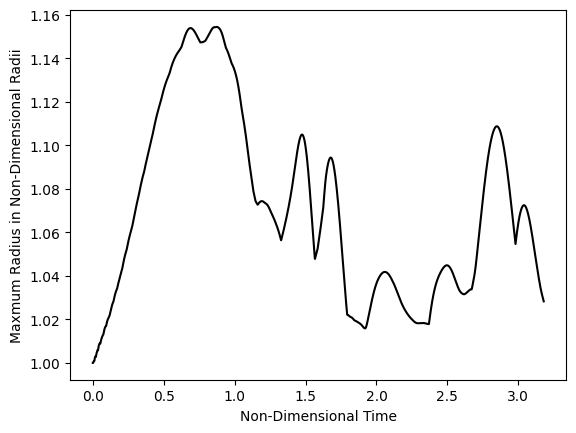

In [16]:
# Maximum Radius

"""
Creates a plot of the maximum droplet radius over time and saves it to a designated path on your computer. 

Inputs/ Uses:
all_maximum_radii_list (list): List of maximum radii at every time step.
t (list): List of all time steps.

Outputs:
plot_path (saved plot): Saves plot on computer.

"""

#Creat times list t for x-axes
t_intervall = len(all_north_poles_list)
t = np.linspace(0, all_north_poles_list[-1].item(), t_intervall)

#Label and show
plt.plot(t, all_maximum_radii_list, color="black")
plt.ylabel("Maxmum Radius in Non-Dimensional Radii")
plt.xlabel("Non-Dimensional Time")
plt.show()

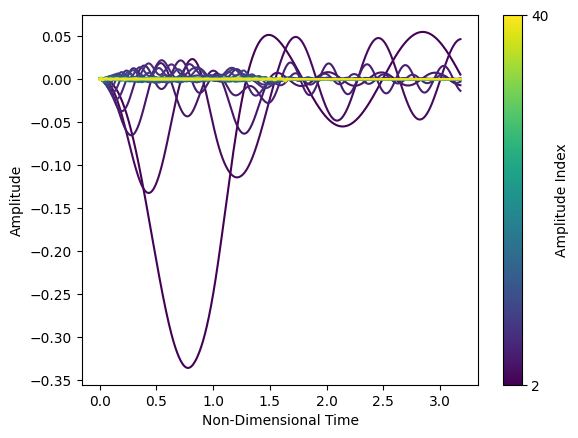

In [17]:
#Mode amplitude plot

all_amps_arr = np.asarray(all_amps_list) #Convert to array for easier handling
def development_of_amplitudes(all_amps_arr):

    fig, ax = plt.subplots()
    colors = cm.viridis(np.linspace(0, 1, n_thetas)) #Choose virdis colormap with number of colors = n_thetas
    
    #Create times list t for x-axes
    t_intervall = len(all_north_poles_list)
    t = np.linspace(0, all_north_poles_list[-1].item(), t_intervall)

    #Plot individual amplitudes with designated colors
    for amp_ind in range(n_thetas-1):
        coefficients_list = []
        for time_ind in range(len(all_amps_arr)):
            coefficients_list.append(all_amps_arr[time_ind, amp_ind][0])
        ax.plot(t, coefficients_list, color=colors[amp_ind])
    
    #Labels
    plt.ylabel("Amplitude")
    plt.xlabel("Non-Dimensional Time")


    #Create a colorbar
    norm = mcolors.Normalize(vmin=2, vmax=n_thetas) #Normalize colorbars by n_thetas
    sm = cm.ScalarMappable(cmap=cm.viridis, norm=norm) #Choose color-scheme (virdis) and normalization

    #Label and show
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_ticks([2, n_thetas])
    cbar.set_ticklabels([2, n_thetas])
    cbar.set_label('Amplitude Index')
    plt.show()

development_of_amplitudes(all_amps_arr)

3D Simulation Videos

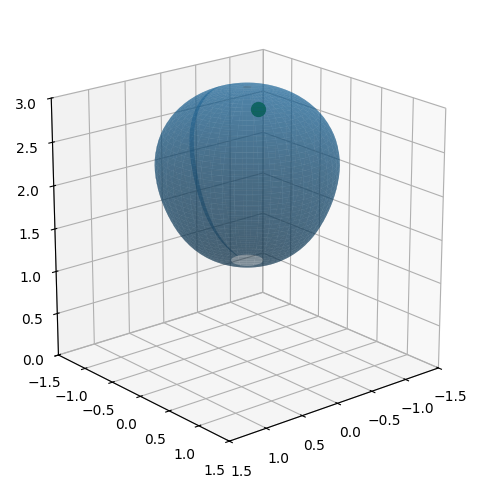

In [18]:
def drop_simulation(all_amps_list, all_h_list, all_m_list, all_times_list, n_thetas_int, speeds, view_vertical = 20, view_horizontal = 50):

    """
    Function that creates a GIF animation of the droplet over time.

    Inputs:
    all_amps_list (list): List of all amplitudes at all time steps.
    all_h_list (list): List of heights of the center of mass of the droplet at every time step.
    all_m_list (list): List of contact points at every time step.
    all_times_list (list): List of all time steps.
    n_thetas_int (int): Number of angles to sample for plotting.
    speeds (int): Speed of simulation (the higher, the faster).
    view_vertical (int): Rotation of the 3D plane in the vertical direction: 0 = straight view (not angled), positive values lead to view from the top.
    view_horizontal (int): Rotation of the 3D plane in the horizontal direction: 0 = straight/ front view (as in 2D), positive values rotate plane to the left (view from the right).

    Outputs:
    Video of simulation.
    
    """

    #view_vertical: Rotation of the 3D plane in the vertical direction: 0 = straight (not angled) view, positive values lead to view from the top
    #view_horizontal: Rotation of the 3D plane in the horizontal direction: 0 = straight/ front view (as in 2D), positive values rotate plane to the left (view from the right)

    #Define Plotting points
    roots_plot, weights = roots_legendre(n_thetas_int) #Choose different number of plotting points (than n_thetas for simulation)
    cos_theta_vec_plot = np.concatenate(([1], np.flip(roots_plot), [-1]))
    theta_vec_plot = np.arccos(cos_theta_vec_plot)

    #Add droplet north and south pole
    thetas_3D = np.concatenate((np.array([-np.pi]),-np.flip(theta_vec_plot[1:]), [0]))

    #Convert to array for easier handling
    all_amps_arr = np.asarray(all_amps_list)

    #Initialize the plot
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(projection='3d')
    ax.set_xlim((-1.5, 1.5))
    ax.set_ylim((-1.5, 1.5))
    ax.set_zlim((-0.5, 2.5))
    ax.view_init(view_vertical, view_horizontal)
    ax.set_box_aspect([1, 1, 1])  
    ax.set_title('Droplet Trajectory and Deformation')

    layers = 100 #Layers of circles of the plots (more layers, more dense plotting)
    phi = np.linspace(0, (np.pi*2) + ((np.pi*2)/layers), layers) #Define phi for spherical plotting
    new_thetas = [theta + 3 * np.pi / 2 for theta in thetas_3D] #Define thetas in radians


    #Initialize plot data

    radii = np.ones(n_thetas_int) #Set undeformed radius
    for i in range(2, n_thetas): #Add deformation of every mode at every angle
        for ind_angles in range(n_thetas_int):
            radii[ind_angles] += all_amps_arr[0, i - 2][0] * Legendre(np.cos(thetas_3D[ind_angles]), i)


        #Transform to xy coordinates
        x = [radii[i] * np.cos(new_thetas[i]) for i in range(n_thetas_int)] 
        z = [radii[i] * np.sin(new_thetas[i]) + 1 - (1- all_h_list[0]) for i in range(n_thetas_int)]

        x_init = np.outer(x, np.sin(phi))
        y_init = np.outer(x, np.cos(phi)) #Create axisymmetry
        z_init = np.zeros_like(x_init)

        for i in range(len(x)):
            z_init[i:i+1,:] = np.full_like(z_init[0,:], z[i])

    #Define plot to add to
    my_plot = ax.plot_surface(x_init, y_init, z_init)

    def drawframe(n): #Run function for remaining time
        if n < len(all_amps_arr):
            radii = np.ones((n_thetas_int)) 
            for i in range(2, n_thetas):
                for ind_angles in range(n_thetas_int):
                    radii[ind_angles] += all_amps_arr[n, i - 2][0] * Legendre(np.cos(thetas_3D[ind_angles]), i)


            x = [radii[i] * np.cos(new_thetas[i]) for i in range(n_thetas_int)]
            z = [radii[i] * np.sin(new_thetas[i]) + 1 - (1- all_h_list[n]) for i in range(n_thetas_int)]

            x_layer = np.outer(x, np.sin(phi))
            y_layer = np.outer(x, np.cos(phi))
            z_layer = np.zeros_like(x_layer)

            for i in range(len(x)):
                z_layer[i:i+1,:] = np.full_like(z_layer[0,:], z[i])

            ax.clear()
            ax.set_xlim((-1.5, 1.5))
            ax.set_ylim((-1.5, 1.5))
            ax.set_zlim((0, 3))
            ax.view_init(view_vertical, view_horizontal)
            ax.set_box_aspect([1, 1, 1])  
            my_plot = ax.plot_surface(x_layer, y_layer, z_layer, alpha=0.5)

            #Indicate whether in contact or not
            if all_m_list[n] != 0:
                my_plot = ax.scatter(-1, -1, 2.5, color="red", s=100)
            else:
                my_plot = ax.scatter(-1, -1, 2.5, color="green", s=100)


        return my_plot,

    anim = animation.FuncAnimation(fig, drawframe, frames=len(all_amps_arr), interval=all_times_list[-1] / speeds, blit=True)

    return HTML(anim.to_html5_video())


#Calling
tend = 100
t = np.linspace(0, tend, tend + 1)
drop_simulation(all_amps_arr, all_h_list, all_m_list, times_list, 50, 20)

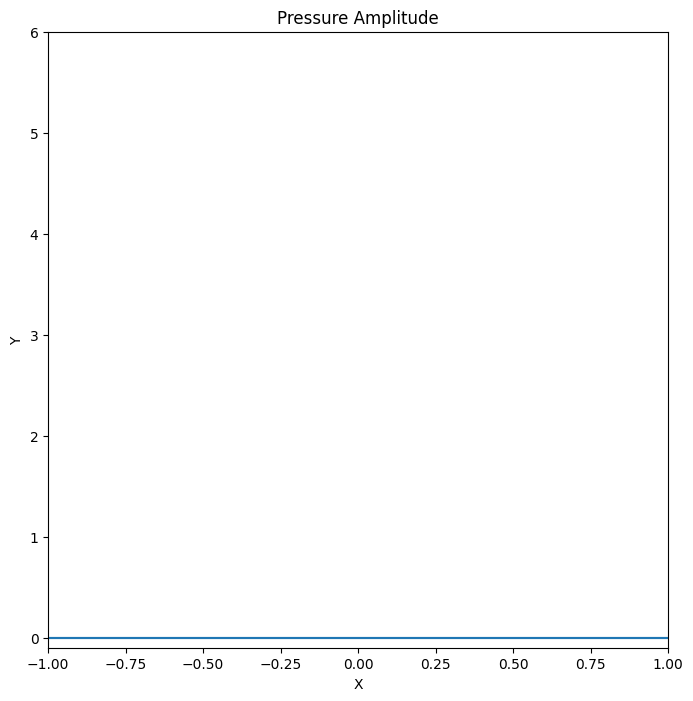

In [19]:
def pressure_simulation(all_press_list, all_times_list, n_thetas_int, speeds):

    """
    Function that creates a GIF animation of the pressure function over time.

    Inputs:
    all_press_list (list):  List of all pressure amplitudes at all time steps.
    all_times_list (list): List of all time steps.
    n_thetas_int (int): Number of angles to sample for plotting.
    speeds (int): Speed of simulation (the higher, the faster).

    Outputs:
    Video of simulation.
    
    """

    #Initialize Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xlim((-1, 1))
    ax.set_ylim((-0.1, 6))
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_title('Pressure Amplitude')
    my_plot, = ax.plot([], [], '-')

    #Obtain sampling angles
    roots, weights = roots_legendre(n_thetas_int)
    float_roots = np.concatenate([np.flip(roots), roots])

    #Convert for easier use
    all_press_arr = np.asanyarray(all_press_list)
    


    def drawframe(n):
        if n < len(all_press_arr):
            pressures = np.zeros(len(float_roots)) #Initialize pressure to 0
            for i in range(n_thetas-1):
                for ind_angles in range(len(float_roots)):
                    pressures[ind_angles] += all_press_arr[n, i][0] * Legendre(np.cos(float_roots[ind_angles]), i)


            my_plot.set_data(float_roots, pressures)

        
        return my_plot,

    anim = animation.FuncAnimation(fig, drawframe, frames=len(all_press_arr), interval=all_times_list[-1] / speeds, blit=True)

    #Return video
    return HTML(anim.to_html5_video())

#Calling
tend = 100
t = np.linspace(0, tend, tend + 1)
pressure_simulation(all_press_list, times_list, 50, 20)